In [1]:
import sys, os
import pickle
import argparse
paths = ['', '..', '../..']
for p in paths:
    if p not in sys.path:
        sys.path.insert(0, p)
import h5py
import matrixprofile as mpf
from matrixprofile.analyze import analyze_mp_exact
from matrixprofile.algorithms import top_k_motifs
import pyscamp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import timeit
import numba
import pathlib
import collections
from numba import cuda
import multiprocessing
import datetime 
from memory_profiler import profile
from matrixprofile.visualize import visualize_md
from matrixprofile import core
import gc
from sklearn import preprocessing
from my_functions import *
import my_transform
from ast import literal_eval
%matplotlib inline

In [2]:
### Compute the multidimensional mp

In [3]:
offset = '60s'
dataset_file = '../data/BEBEZE01_scada_high_frequency.parquet'
df = pd.read_parquet(dataset_file)
# pick the most important columns

cols = ['wind speed', 'active power', 'rotor speed', 'pitch angle', 'sin_wind_dir', 'sin_nacelle_dir', 'cos_wind_dir', 'cos_nacelle_dir']
df = df[cols]
print(df.columns)

### Scale each column to 0-1

min_max_scaler = preprocessing.MinMaxScaler()
df[df.columns] = min_max_scaler.fit_transform(df)

### Resample with a 60sec offset
df.index = pd.to_datetime(df.index)
df = df.resample(offset).mean()

### add small noise to series
df = add_noise_to_series_md(df, noise_max = 0.00009)

### Keep only one month before and ofther the fringe measurements
start = '2018-07-02'
end = '2019-01-11'
df = filter_dates(df, start, end)
df = df[:5000]

m = 20 # window size
include = ['active power']
col_indexes = []
for n in include:
    col_indexes.append(df.columns.get_loc(n))
    
mps, indices = mstump(df, m, include = col_indexes)
motifs_idx = np.argsort(mps, axis=1)[:, :2]
mp_len = mps.shape[0]

output_dir = './test_mp/'
output_name = 'test'
save_mdmp_as_h5(output_dir, output_name, mps, indices)

print("Finished")

Index(['wind speed', 'active power', 'rotor speed', 'pitch angle',
       'sin_wind_dir', 'sin_nacelle_dir', 'cos_wind_dir', 'cos_nacelle_dir'],
      dtype='object')
Finished


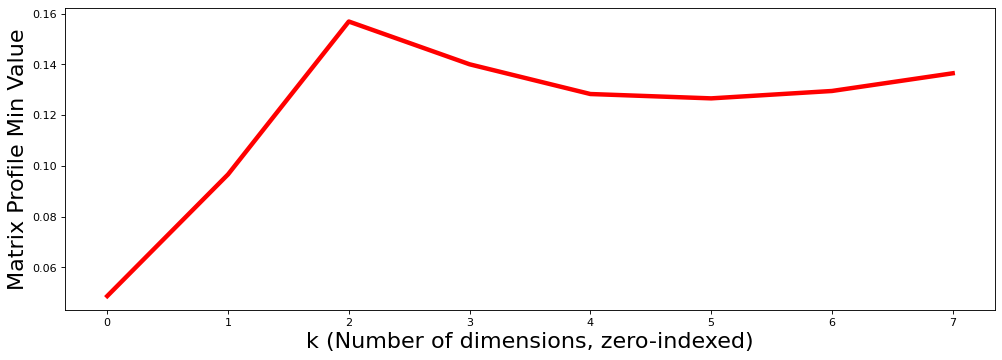

In [4]:
plot_knee(mps)

In [5]:
k = 2
include = ['active power']
df =  pick_subspace_columns(df, mps, indices, k, m, include)
df.head()

Include dimensions: ['active power'], indexes in df = [1]
For k = 2, the 3-dimensional subspace includes subsequences from ['active power' 'pitch angle' 'rotor speed']


,active power,pitch angle,rotor speed
datetime,,,
2018-07-02 00:00:00,0.251330,0.536007,0.630321
2018-07-02 00:01:00,0.261893,0.536007,0.632687
2018-07-02 00:02:00,0.254318,0.535990,0.626823
2018-07-02 00:03:00,0.278360,0.535986,0.633175
2018-07-02 00:04:00,0.267592,0.535982,0.635406


In [6]:
mp, index = load_mdmp_from_h5(output_dir, output_name, k)
profile = compute_mp_av(mp, index, m, df, k)
output_name = output_name + '_av'
save_mdmp_as_h5(output_dir, output_name, profile['cmp'], profile['pi'], k)

Making multi-dim av...


In [7]:
mp, index = load_mdmp_from_h5(output_dir, output_name, k)
ezones = [0.5, 1]
radii = [2, 3]
segment_labels = ['aligned', 'misaligned']
output_list_full = []
for radius in radii:
    for ez in ezones:
        topk = 5
        max_neighbors = 20
        profile = get_top_k_motifs(df, mp, index, m, ez, radius, k=topk, max_neighbors=max_neighbors)

        m1 = (df.index >= '2018-07-03')
        mask = np.logical_or.reduce([m1])

        output_list = calculate_motif_stats(profile, mask, topk, m, ez, radius, segment_labels)

        results_dir = 'results_test'
        sub_dir_name = 'results' + str(m) + '_' + str(ez) + '_' + str(radius)
        df_output = pd.DataFrame(output_list, columns=['k', 'motif', 'nearest neighbor',
                                                       'aligned', 'misaligned', 'cost', 
                                                       'window_size', 'exclusion_zone', 'radius',
                                                       'motif indices', 'majority'])
        #save_results(results_dir, sub_dir_name, profile, df_output, m, radius, ez, topk, max_neighbors)

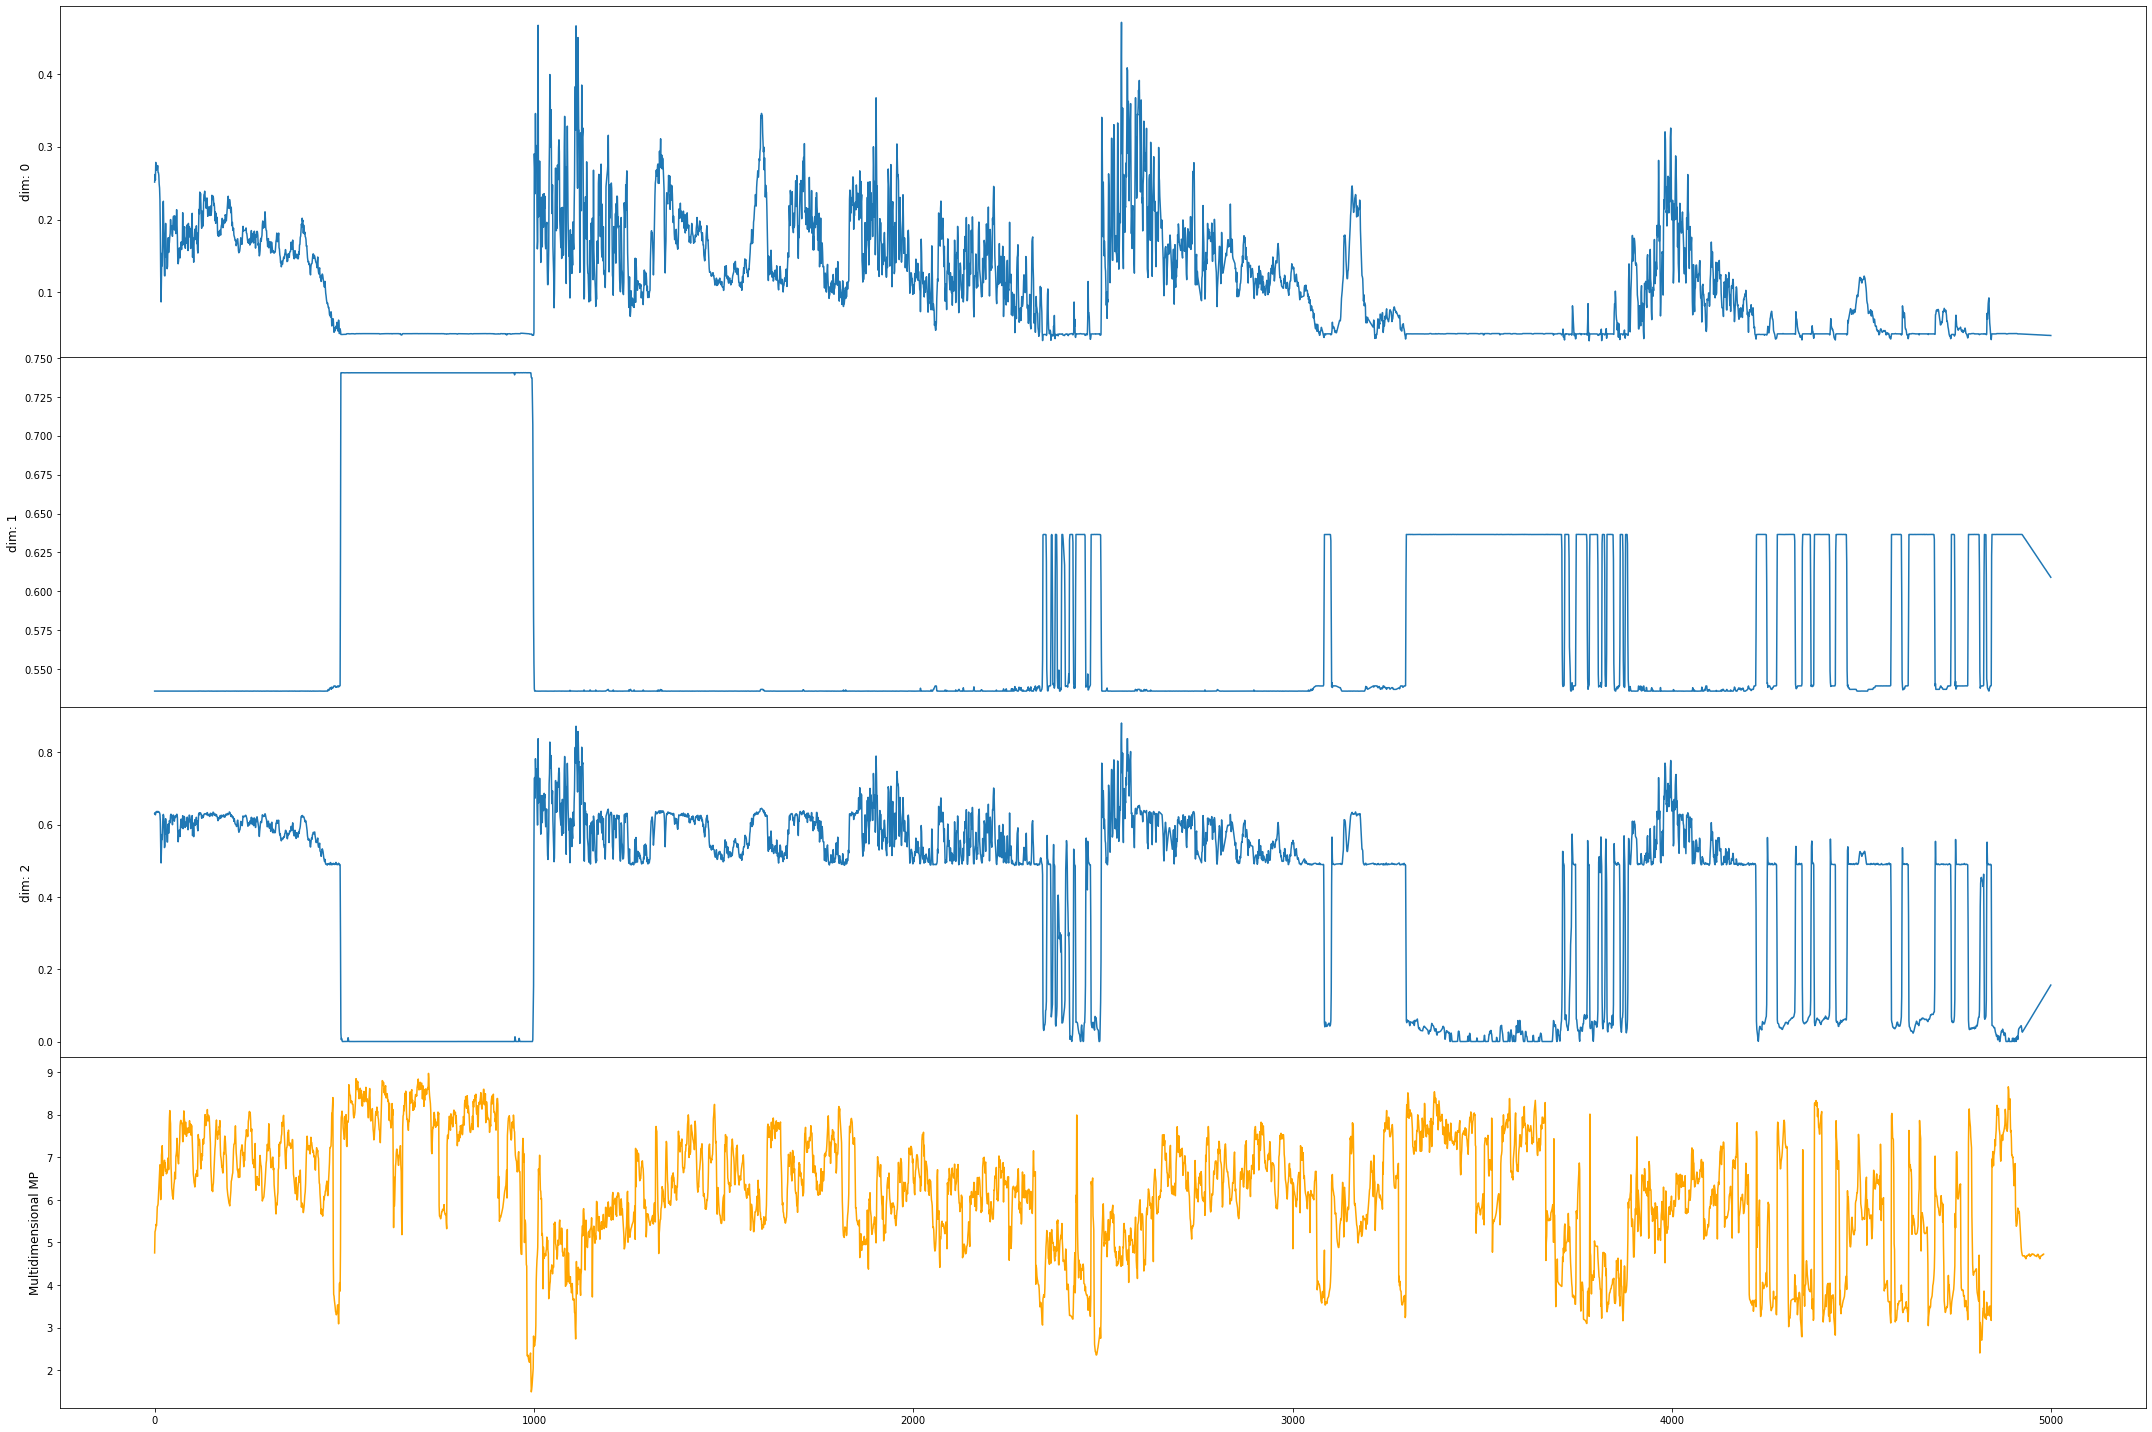

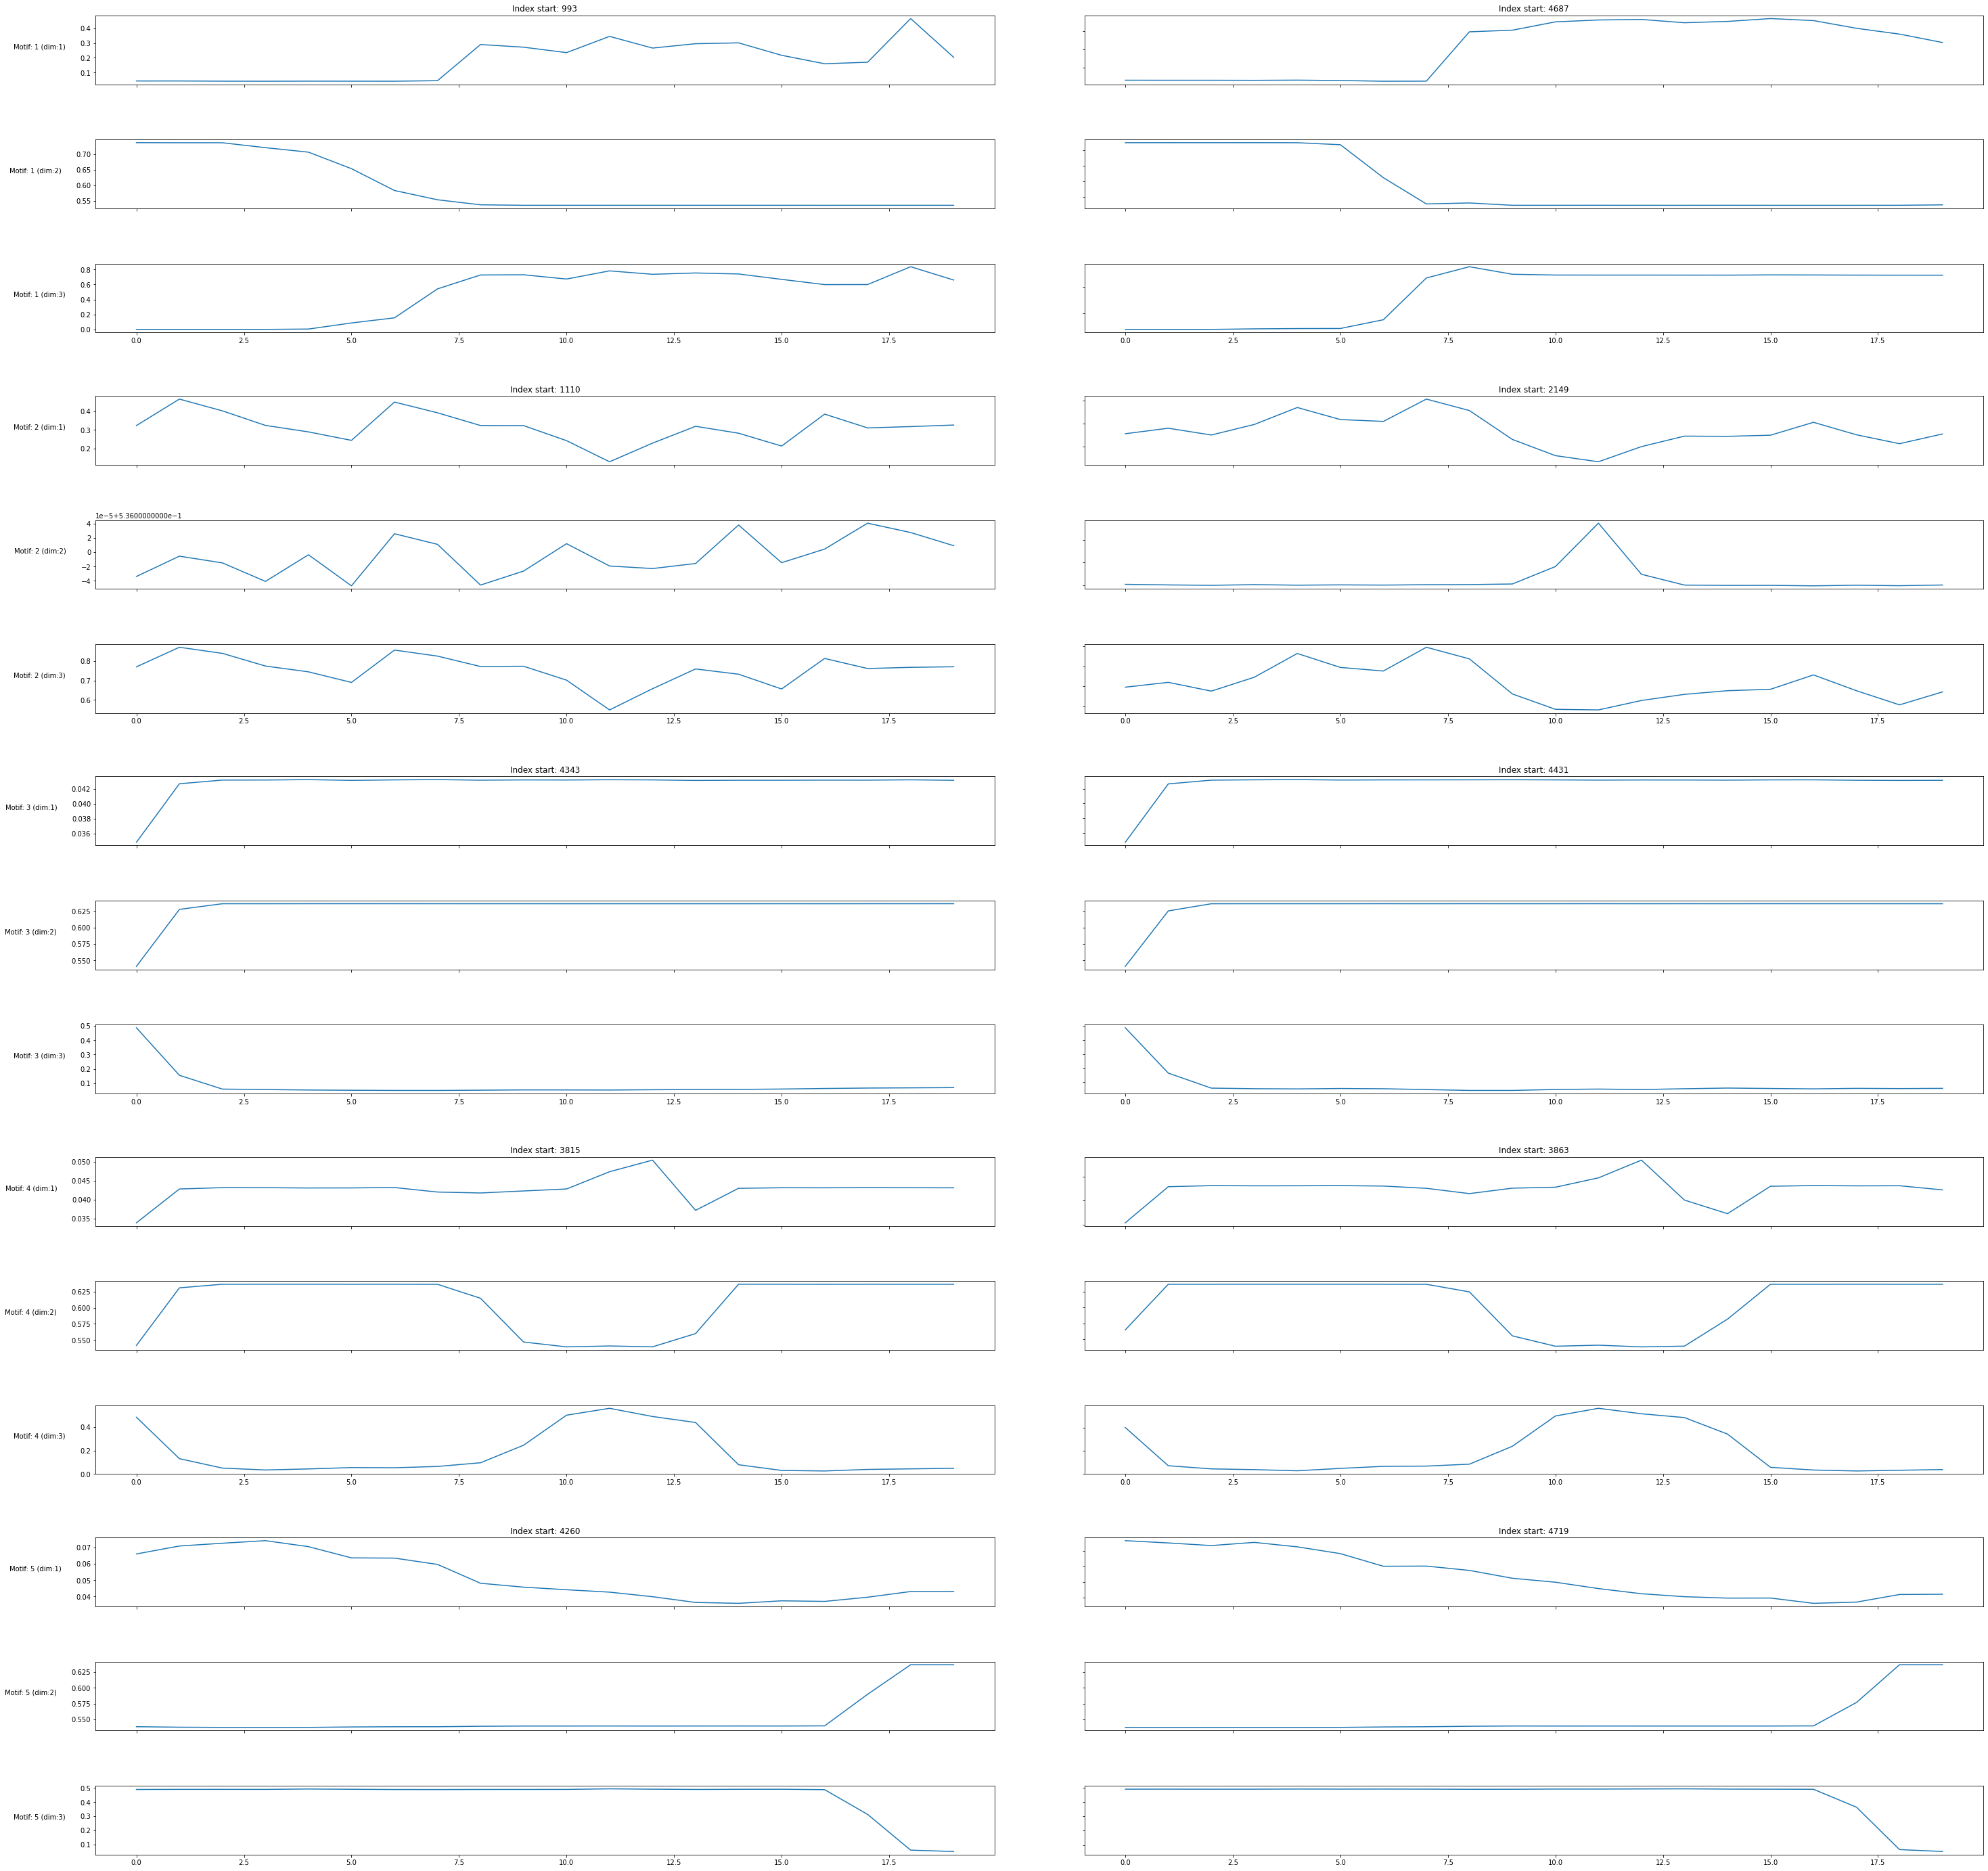

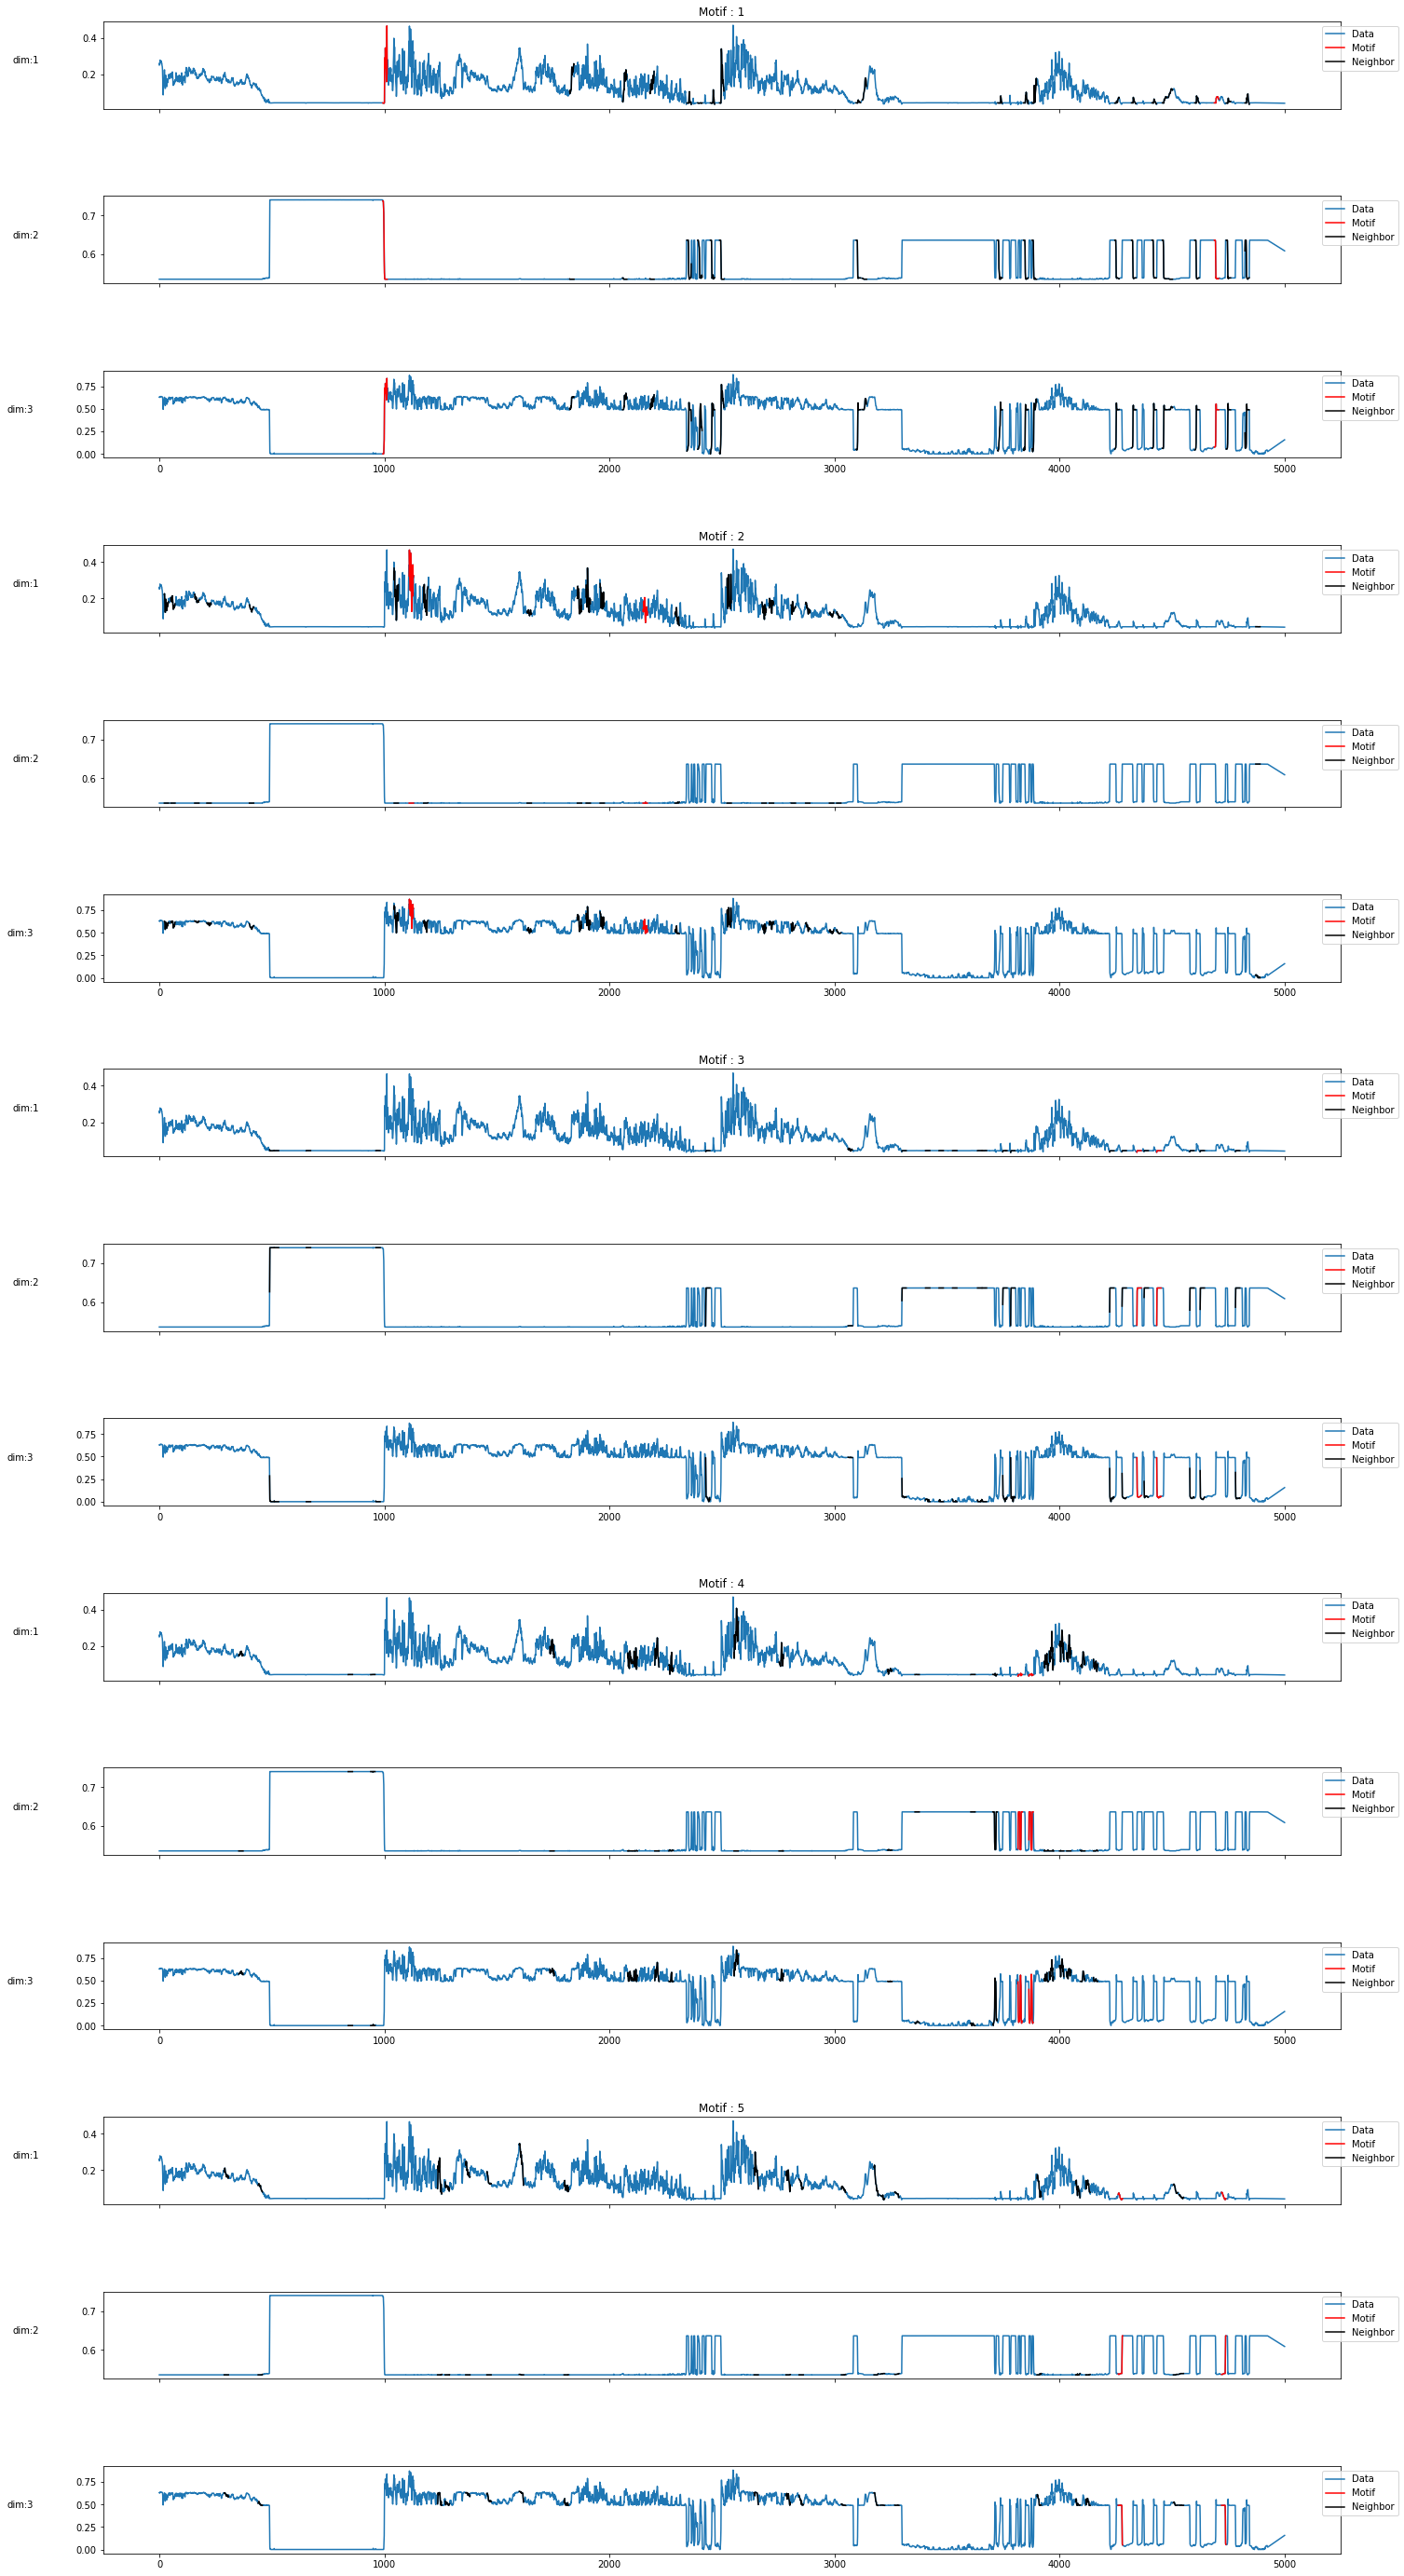

In [8]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    visualize_md(profile)

In [9]:
summary_name = './summarized_results_test.csv'
df_output = pd.DataFrame(output_list, columns=['k', 'motif', 'nearest neighbor', 'aligned', 'misaligned', 'cost', 'window_size', 'exclusion_zone', 'radius',
                                        'motif indices', 'majority'])
df_output.to_csv(summary_name, index=False)

In [10]:
offset = '60s'
dataset_file = '../data/BEBEZE02_scada_high_frequency.parquet'
df2 = pd.read_parquet(dataset_file)
# pick the most important columns

cols = ['wind speed', 'active power', 'rotor speed', 'pitch angle', 'sin_wind_dir', 'sin_nacelle_dir', 'cos_wind_dir', 'cos_nacelle_dir']
df2 = df2[cols]
print(df2.columns)

### Scale each column to 0-1

min_max_scaler = preprocessing.MinMaxScaler()
df2[df2.columns] = min_max_scaler.fit_transform(df2)

### Resample with a 60sec offset
df2.index = pd.to_datetime(df2.index)
df2 = df2.resample(offset).mean()

### add small noise to series
df2 = add_noise_to_series_md(df2, noise_max = 0.00009)

### Keep only one month before and ofther the fringe measurements
start = '2018-07-02'
end = '2019-01-11'
df2 = filter_dates(df2, start, end)
df2 = df2[:5000]
k = 2
include = ['active power']
df2 =  pick_subspace_columns(df2, mps, indices, k, m, include)

Index(['wind speed', 'active power', 'rotor speed', 'pitch angle',
       'sin_wind_dir', 'sin_nacelle_dir', 'cos_wind_dir', 'cos_nacelle_dir'],
      dtype='object')
Include dimensions: ['active power'], indexes in df = [1]
For k = 2, the 3-dimensional subspace includes subsequences from ['active power' 'pitch angle' 'rotor speed']


In [11]:
df_summary = pd.read_csv(summary_name)
df_summary = df_summary.drop(df_summary[df_summary['majority'] == 'None'].index)
df_summary.sort_values(by='cost', inplace=True)
df_summary.reset_index(drop=True, inplace=True)
df_summary.head()

,k,motif,nearest neighbor,aligned,misaligned,cost,window_size,exclusion_zone,radius,motif indices,majority
0,1,misaligned,aligned,20,2,0.396437,20,1,3,"[993, 4687]",aligned
1,4,aligned,aligned,19,3,0.561514,20,1,3,"[3815, 3863]",aligned
2,3,aligned,aligned,18,4,0.709163,20,1,3,"[4343, 4431]",aligned
3,2,misaligned,aligned,13,9,0.737589,20,1,3,"[1110, 2149]",misaligned
4,5,aligned,aligned,17,5,0.842006,20,1,3,"[4260, 4719]",aligned


In [12]:
pairs = []
exclusion_zones = []
majorities = []
print(df_summary.shape)

# at most 5 of the lowest cost pairs
for i in range(0, min(5, df_summary.shape[0])):
    pairs.append(literal_eval(df_summary.loc[i, 'motif indices']))
    exclusion_zones.append(df_summary.loc[i, 'exclusion_zone'])
    majorities.append(df_summary.loc[i, 'majority'])

print(pairs)
print(exclusion_zones)
print(majorities)

(5, 11)
[[993, 4687], [3815, 3863], [4343, 4431], [1110, 2149], [4260, 4719]]
[1, 1, 1, 1, 1]
['aligned', 'aligned', 'aligned', 'misaligned', 'aligned']


In [13]:
# calculate the distances between the two segments of each motif pair
ts1 = df.values
ts2 = df2.values
pair_dists = []
for pair in pairs:
    indx1, indx2 = pair
    q = ts1[indx1:indx1+m] 
    t = ts1[indx2:indx2+m] 
    pdist = pairwise_dist(q, t)
    pair_dists.append(pdist)
    
# for each part of each motif pair find the closest neighbors and their distances
nn_list = []
nn_dists_list = []
for pair, dist, ez in zip(pairs, pair_dists, exclusion_zones):
    exclusion_zone = int(np.floor(m * ez))
    idx1, idx2 = pair
    q1 = ts1[idx1:idx1+m] 
    q2 = ts1[idx2:idx2+m] 
    
    nn, nn_dists = find_neighbors(q1, ts2, m, exclusion_zone=exclusion_zone, min_dist=dist)
    nn_list.append(nn)
    nn_dists_list.append(nn_dists)
    
    nn, nn_dists = find_neighbors(q2, ts2, m, exclusion_zone=exclusion_zone, min_dist=dist)
    nn_list.append(nn)
    nn_dists_list.append(nn_dists)


In [14]:
def generate_output_row(q, nn_list, nn_dists_list, pair_dist, segment_labels, maj_other):
    if not nn_list == [] and not nn_dists_list ==[]:
        min_neighbor_dist = nn_i_dists[0]
        avg_neighbor_dist = np.mean(nn_i_dists)
        res_row = [q_idx1, pair_dist, min_neighbor_dist, avg_neighbor_dist]
        res = calculate_nn_stats(nn_i, mask, m, ez, segment_labels, maj_other)
        res_row.extend(res)
    return res_row

In [15]:
result_rows = []
i = 0
# for each part of each motif pair calculate statistics and save
for q_idx_pair, maj, pair_dist, ez in zip(pairs, majorities, pair_dists, exclusion_zones):
    q_idx1, q_idx2 = q_idx_pair
    
    nn_i = nn_list[i]
    nn_i_dists = nn_dists_list[i]
    res_row = generate_output_row(q_idx1, nn_i, nn_i_dists, pair_dist, segment_labels, maj)
    result_rows.append(res_row)
    i+=1
    
    nn_i = nn_list[i]
    nn_i_dists = nn_dists_list[i]
    res_row = generate_output_row(q_idx2, nn_i, nn_i_dists, pair_dist, segment_labels, maj)
    result_rows.append(res_row)
    i+=1
    
output_name = 'test'
df_output = pd.DataFrame(result_rows, columns=['pattern_idx_in_ts1', 'motif_pair_dist', 
                                               f'Closest neighbor dist in ts2', 
                                               f'Average neighbor dist in ts2',
                                               f'NNs in ts2 indices', 
                                               'aligned', 'misaligned', 'exclusion_zone', 'cost',
                                               'matching_majority'])
df_output.head(10)

,pattern_idx_in_ts1,motif_pair_dist,Closest neighbor dist in ts2,Average neighbor dist in ts2,NNs in ts2 indices,aligned,misaligned,exclusion_zone,cost,matching_majority
0,993,1.443596,1.237174,3.378966,"[415, 4459, 3881, 3104, 1855, 4741, 4596, 3842...",50,22,1,0.957956,False
1,993,1.443596,0.983022,3.249279,"[414, 4596, 1855, 3880, 4459, 4822, 2485, 3104...",49,24,1,0.904615,False
2,3815,1.829054,4.247904,5.015363,"[3784, 4184, 3073, 1460, 609, 4842, 4781, 4497...",75,24,1,0.883375,True
3,3815,1.829054,4.183765,5.012973,"[4183, 3768, 3814, 589, 4497, 1460, 1833, 4475...",74,26,1,0.929691,True
4,4343,0.156897,0.351559,0.390614,"[4283, 4841, 4781, 4218, 4620]",5,0,1,0.000000,True
5,4343,0.156897,0.354975,0.423065,"[4841, 4283, 4781]",3,0,1,0.000000,True
6,1110,5.231029,4.030969,4.797204,"[1109, 4034, 1302, 1222, 1336, 785, 2804, 4072...",63,37,1,0.815681,True
7,1110,5.231029,2.973582,4.581453,"[859, 835, 4072, 1821, 2912, 3262, 3896, 381, ...",62,38,1,0.795155,True
8,4260,0.627198,1.105589,1.551675,"[3056, 4327, 4604, 1915, 4266, 4764]",6,0,1,0.000000,True
9,4260,0.627198,1.262691,1.457775,"[3056, 4327, 4764, 4266, 4603, 1915]",6,0,1,0.000000,True
